## Business Understanding

Since the introduction of the Nintendo Entertainment System in 1985 there has been a proliferation of new and more advanced gaming systems and videogames introduced to the global market. Though many companies likely have methods and tools to predict the success of new games, new and emerging tools may better position publishers to determine the potential success of a game based on the characteristics of a videogame. Putting predictive tools in the hands of manufacturers and marketers may reduce their risk of releasing a game that may not give a good return on investment and allows the company to invest their resources in projects that would have a higher likelihood of success.

## Data Understanding

The [Sglobale Dataset](https://data.world/julienf/video-games-global-sales-in-volume-1983-2017) contains over 16,500 records of sales for individual videogames in each major market from 1980 through 2020 including North America, Europe, and Japan ranked by the total global sales for that game. The dataset also contains the title, platform, genre, and publisher for each entry in the dataset.  More data was collected using an IGDP API request,  this data contains numerous rows that have information about some of the games that are included in the Sglobale dataframe.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import requests
import json
import warnings
import pickle
import random
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from io import BytesIO
from datetime import datetime
from igdb.wrapper import IGDBWrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

## Data Preparation 

Once downloaded the sglobal dataset could be accessed via Pandas using the .read_csv method.  Inspecting the data showed NA_Sales, JP_Sales, EU_Sales, and Other_Sales' total were equal to the Global_Sales column and were dropped to prevent multicollinearity. Rank was dropped as it was a count of the number of videogames in ascending order and added nothing to the features that could have been predicted on.  The Name column was dropped later to prevent difficulties with one hot encoding the data, limiting functionality.  The values Wii Sports and Super Mario Brothers were dropped due to the fact they were originally bundled with their parent gaming platform which caused them to have inflated sales values.  The Data point that was the sole game from 2020 was dropped since it could cause issues with the spread of data in the years column and the ability of the model to predict on that feature. The final entries in the datset to be dropped were the comparitively small number of NaN values that would not cause a large loss in data. 

In [2]:
sglobal = pd.read_csv('../Data/vgsalesGlobale2.csv')
sglobal.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
sglobal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16598 non-null int64
Name            16598 non-null object
Platform        16598 non-null object
Year            16327 non-null float64
Genre           16598 non-null object
Publisher       16540 non-null object
NA_Sales        16598 non-null float64
EU_Sales        16598 non-null float64
JP_Sales        16598 non-null float64
Other_Sales     16598 non-null float64
Global_Sales    16598 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


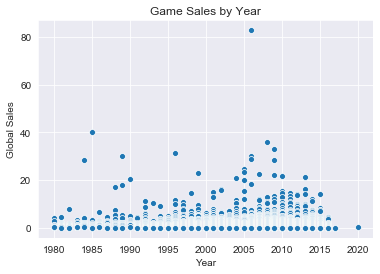

In [4]:
sns.set_style('darkgrid')
sns.scatterplot(sglobal.Year, sglobal.Global_Sales)
plt.title('Game Sales by Year')
plt.ylabel('Global Sales')
plt.show();

#### Dropping columns

In [5]:
# Name column will be dropped later
sglobal.drop(columns=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Rank'], axis=1, inplace=True)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37


#### Dropping individual datapoints

In [6]:
sglobal.drop(index=[0, 1, 5957], inplace = True)

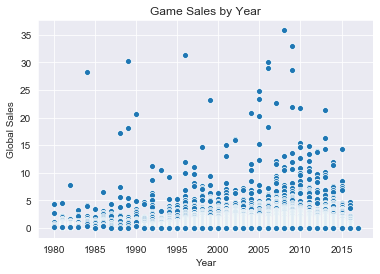

In [7]:
sns.set_style('darkgrid')
sns.scatterplot(sglobal.Year, sglobal.Global_Sales)
plt.title('Game Sales by Year')
plt.ylabel('Global Sales')
plt.show();

#### Dropping NaN values

In [8]:
sglobal.dropna(inplace=True)
sglobal.isna().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
Global_Sales    0
dtype: int64

In [9]:
sglobal.reset_index(drop=True, )
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37
5,Tetris,GB,1989.0,Puzzle,Nintendo,30.26
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01


#### Creating another feature

Due to the lack of features on which the model could predict, another feature was created to identify if a game has been remade using the Name and Global_Sales columns.  Once the Remake column was created the Name column was dropped as it was no longer needed.

In [10]:
remake = np.array(sglobal['Name'].duplicated())
remake_df = pd.DataFrame(remake, columns=['Remake'], index=sglobal.index)
remake_df.head()

,Remake
2,False
3,False
4,False
5,False
6,False


In [11]:
sglobal = pd.concat((sglobal,remake_df), axis=1)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,False
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,False
5,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,False
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,False


In [12]:
sglobal['Remake'] = sglobal['Remake'].astype(int)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,0
5,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,0
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,0


In [12]:
sglobal_nn = sglobal.drop('Name', axis='columns')
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,False
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,False
5,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,False
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,False


## Coding the first model

In [13]:
y = sglobal_nn['Global_Sales']
X = sglobal_nn.drop('Global_Sales', axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [15]:
# OneHotEncoding X_train and X_test columns

ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train[['Platform', 'Genre', 'Publisher']])

ohe_cats = pd.DataFrame(ohe.transform(X_train[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_train.index)

ohe_cats_test= pd.DataFrame(ohe.transform(X_test[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_test.index)


In [16]:
# Dropping the unnecessary columns
X_train.drop(columns=['Platform', 'Genre', 'Publisher'], axis=1, inplace=True)
X_test.drop(columns=['Platform', 'Genre', 'Publisher'], axis=1, inplace=True)

In [17]:
# Concatenating the one hotted columns
X_train_ohe = pd.concat((X_train, ohe_cats), axis=1)
X_test_ohe = pd.concat((X_test, ohe_cats_test), axis=1)

In [18]:
X_train_ohe.head()

,Year,Remake,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,...,x2_Zoo Digital Publishing,x2_Zoo Games,x2_Zushi Games,x2_bitComposer Games,x2_dramatic create,x2_fonfun,x2_iWin,x2_imageepoch Inc.,"x2_mixi, Inc",x2_responDESIGN
3529,2013.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14872,2002.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4825,2011.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16538,2007.0,True,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8814,2003.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_test_ohe.head()

,Year,Remake,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,...,x2_Zoo Digital Publishing,x2_Zoo Games,x2_Zushi Games,x2_bitComposer Games,x2_dramatic create,x2_fonfun,x2_iWin,x2_imageepoch Inc.,"x2_mixi, Inc",x2_responDESIGN
8067,1993.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2414,2007.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13821,2009.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2284,2009.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7379,2001.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## The First Model

In [19]:
ss = StandardScaler()

X_train_ohe_ss = ss.fit_transform(X_train_ohe)
X_test_ohe_ss = ss.transform(X_test_ohe)

In [20]:
random.seed(42)
linreg = LinearRegression()

linreg.fit(X_train_ohe_ss, y_train)

print(linreg.score(X_train_ohe_ss, y_train))
print(mean_absolute_error(y_train, linreg.predict(X_train_ohe_ss)))

0.16314880624170602
0.5082680456230857


In [21]:
cross_val_score(linreg, X_train_ohe_ss, y_train, cv=3)

array([-1.66160013e+28, -1.32211097e+28, -5.37127152e+27])

In [22]:
print(linreg.score(X_test_ohe_ss, y_test))
print(mean_absolute_error(y_test, linreg.predict(X_test_ohe_ss)))

-1.0322221832748807e+24
116325050948.14445


Text(0, 0.5, 'Projected Sales')

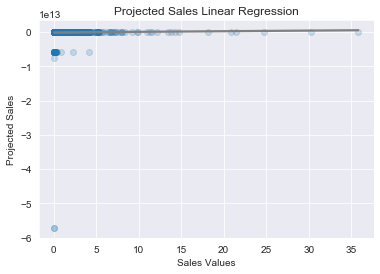

In [23]:
sns.set_style('darkgrid')
sns.regplot(y_test, linreg.predict(X_test_ohe_ss), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.title('Projected Sales Linear Regression')
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales')

Text(0, 0.5, 'Residuals')

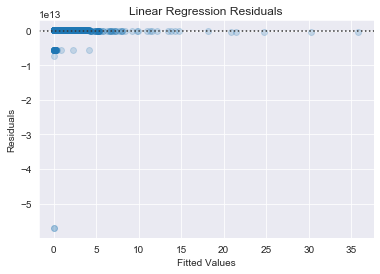

In [24]:
sns.residplot(y_test, linreg.predict(X_test_ohe_ss), scatter_kws={'alpha': 0.2})
plt.title('Linear Regression Residuals')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

## Evaluation of First Model

This model, a linear regression, was run to identify how well a regression would fit to the features using a basic supervised model without any regularization.  The results clearly show the model does not perform well with the features as they are.  The low r2 score of .16 in tandem with an MAE of .50  in the results of the training data show a low distrbution about the mean and low accuracy in the predictions of the model.  In addition, the even lower r2 of -1 and much higher MAE twelve digits in length in the validation scores show the model does not generalize well to new data proving underfitness and a possible need for regularization.

## Second Model

In [25]:
ridge = Ridge(alpha=4, random_state=42)

ridge.fit(X_train_ohe_ss, y_train)
print(ridge.score(X_train_ohe_ss, y_train))
print(mean_absolute_error(y_train, ridge.predict(X_train_ohe_ss)))

0.16499160849758898
0.5022355507985229


In [26]:
cross_val_score(ridge, X_train_ohe_ss, y_train, cv = 3).mean()

0.13941634925575688

In [27]:
print(ridge.score(X_test_ohe_ss, y_test))
print(mean_absolute_error(y_test, ridge.predict(X_test_ohe_ss)))

0.14442091402955515
0.5327002779301154


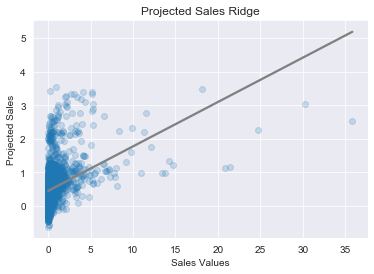

In [29]:
sns.regplot(y_test, ridge.predict(X_test_ohe_ss), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.title('Projected Sales Ridge')
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales');

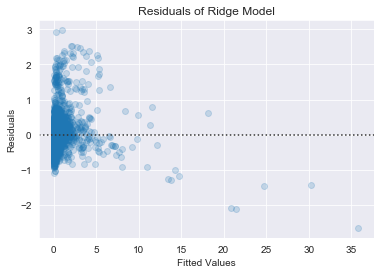

In [30]:
sns.residplot(y_test, ridge.predict(X_test_ohe_ss), scatter_kws={'alpha': 0.2})
plt.title('Residuals of Ridge Model')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals');

## Second Model Evaluation

Ridge Regression was chosen to adjust the coefficients without lowereing them to zero in order to raise the variance thereby raising the scores from the validation data.  This did not prevent the model from being underfit. The training data in this model gave results that were slightly better compared to those in the linear regression model the difference being a .1 increase in the r2 score.  The greatest difference for this model was in the scores from the test data.  The r2 score at .19 and the MAE at .70 are a dramatic change in comparison to the original scores returned by the linear regression model. However, the reg plot has shown the difficulty the model had in predicting on a dependent variable, by visualizing more easily where the data is better predicted at lower values than at higher values demonstrating how the reliability of the predictions were somewhat untrustworthy. Meanwhile, the residuals plot identified the necessity to move away from a more basic linear regression where it had shown the heteroskedasticity of the data.  The low r2 score is likely attributed to the low number of features.  For this reason more data was collected.

## Data Collection

To collect data from [IGDB](pi-docs.igdb.com/#about) create a twitch account.  If the instructions are follwed at the account creation site for Twitch.tv there shouldn't be a major problem.  When filling in the application the OAuth url was set as "http://localhost" to let the system know the data will be run locally then choose analytics tool from the category menu.  Once the application is accepted  a client ID is assigned to you and you can ask for a client secret.  Though this secret is used in the code to collect the data it should not be made public. As such once the code has been run it should be written down or saved to the computer and then deleted from the code.  Once the client ID and client secret have been collected an access token will be needed to collect the data from IGDB.  The request URL is found under the authentification section of the instructions and the client ID and client secret can be filled in to make a successful request.  A wrapper was created to deliver the data in a format compatible with python under wrappers, however, the readme file that shows how to run the data contains an issue that throws an error.  The solution can be found in a discussion entitled 'Main Readme Example Does Not Work' under the issues tab.  

In [ ]:
!pip install igdb-api-v4 #Installs the wrapper

In [ ]:
# Don't upload your client secret
client_ID = 'ryht2y9jvswue4yv5ddm894h7qvxdn'
client_secret = # Removed for security reasons!

r = requests.post(f"https://id.twitch.tv/oauth2/token?client_id={client_ID}&client_secret={client_secret}&grant_type=client_credentials")
access_token = json.loads(r._content)['access_token']
wrapper = IGDBWrapper(client_ID, access_token)

In [ ]:
# converts the information collected with the wrapper into JSON format
def bytes_to_json(byte_array):
    _  = BytesIO(byte_array)
    return json.loads(_.read())

The data collected was for the games in the sglobal dataset. Therefore, the names of the games were used to identify which game data should be returned.  This did not mean that the website would have data on all the games requested so a try/except was set up to allow the request to return None if there was no data such that the request would not throw an error if there were a NaN value.  The final issue to consider when working with this API is that the rate limit for requests is four per second.  For this reason, a counter was set up to space out the information returned which told the machine to wait if it thought the rate would exceed the limit.

In [ ]:
now = datetime.now
window_open=now()
count=0
data=[]
with tqdm(total=len(sglobal)) as pbar:
    for name in sglobal.Name:
        try:
            byte_array = wrapper.api_request(
                    'games',
                    f'fields *; where name = "{name}";'
            )
            game_info = bytes_to_json(byte_array)
            if not game_info:
                game_info=[None]
        except:
            game_info=[None]

        data.append(game_info[0])
        # the rate monitor
        count+=1
        if count % 4 == 0:
            window_close=now()
            difference= window_close-window_open
            if difference.total_seconds() <= 1:
                sleep(1)
            window_open=now()
        pbar.update(1)

#### Pickling 

Due to the two hour window it takes to retrieve the data from IGDB, a pickle file was created to prevent the need to run the API code to access the data a second time. The pickling method saves the API data to file for later access and is preferable as it can reload the data in seconds.

In [ ]:
# Running this cell saves an instance of the collected data
filename = 'Igdb_data'
outfile = open(filename, 'wb')

pickle.dump(data, outfile)
outfile.close()

In [31]:
# Running this cell will import the collected data if there is a problem
infile = open('Igdb_data','rb')
new_data = pickle.load(infile)
infile.close()

## Creating new features

The first order of business for this new data was to remove the values that were collected that had a value of None and then put the data into a dataset so it could be filtered and organized.  Not all the columns in valid_data were useful for prediction since many of the columns either contained data types that contained far too many NaN values to be considered or were datatypes that were not translatable to numeric data such as text.  In addition, of the data that could be used, nearly every column contained entries that were lists of entry codes that would need to be translated in order to be comprehensive.  For this reason only certain columns were usable and of those, nearly all had to be translated into a set of data conducive to prediction by the model.

In [32]:
valid_data = [] 
for val in new_data: 
    if val != None : 
        valid_data.append(val)

In [42]:
# Running this cell affects how well the notebook functions due to the contents being a large list of dictionaries
valid_data 

In [33]:
pd.set_option('display.max_columns', None)
new_cols = pd.DataFrame(valid_data)
new_cols.drop_duplicates(subset='id', inplace=True)
new_cols['id'].value_counts()

67583    1
50578    1
13676    1
44858    1
49960    1
        ..
717      1
4815     1
69164    1
15058    1
20482    1
Name: id, Length: 7613, dtype: int64

In [34]:
new_cols.head()

,id,age_ratings,aggregated_rating,aggregated_rating_count,alternative_names,bundles,category,collection,cover,created_at,external_games,first_release_date,follows,game_modes,genres,involved_companies,keywords,name,platforms,player_perspectives,rating,rating_count,release_dates,screenshots,similar_games,slug,summary,tags,themes,total_rating,total_rating_count,updated_at,url,videos,websites,checksum,franchise,franchises,storyline,multiplayer_modes,artworks,game_engines,standalone_expansions,hypes,dlcs,expansions,status,version_parent,version_title,parent_game
0,2181,"[189, 26427]",75.00,3.0,[32754],"[130310, 136311]",0,681.0,86110.0,1372204800,"[35583, 144876, 221465, 245925, 1928625, 19289...",1.163894e+09,34.0,"[1, 2, 4]","[13, 14]","[4658, 22251]","[20, 30, 56, 274, 299, 311, 632, 977, 992, 116...",Wii Sports,[5],"[1, 2]",75.179950,191.0,"[27256, 27257, 27258, 27259]","[10247, 10248, 10249, 10250, 10251, 178474, 17...","[1244, 1352, 2182, 2185, 2186, 2194, 3915, 488...",wii-sports,Bowl like a pro or go for that home run...\nEx...,"[40, 268435469, 268435470, 536870932, 53687094...",[40],75.089975,194.0,1606521600,https://www.igdb.com/games/wii-sports,[1276],"[570, 125920]",666375f9-8638-d37d-f7c0-31dcfe26d3eb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,358,"[24, 24927]",NaN,NaN,"[31808, 31809, 31810, 31811, 31812, 31813, 31814]","[5199, 9250, 69638, 77227, 77785]",0,6118.0,97418.0,1300320000,"[30094, 142871, 190087, 220718, 1611061]",4.954176e+08,363.0,"[1, 2]","[8, 31]","[97362, 97363]","[16, 137, 226, 296, 394, 432, 558, 594, 846, 1...",Super Mario Bros.,"[5, 18, 24, 37, 41, 51, 130, 307]",[4],83.855032,807.0,"[143761, 143763, 143764, 143765, 143766, 14376...","[379065, 379066, 379067, 379068, 379069]","[1067, 1068, 1075, 1078, 1079, 2180, 3340, 334...",super-mario-bros,A side scrolling 2D platformer and first entry...,"[1, 268435464, 268435487, 536870928, 536871049...",[1],83.855032,807.0,1606521600,https://www.igdb.com/games/super-mario-bros,"[35300, 35301]","[4549, 4550]",f01c3fd3-d930-67b8-9ebf-4ea29ccfb8f4,24.0,"[24, 845]","One day, the Mushroom Kingdom was invaded by t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2183,"[192, 13218]",71.25,5.0,"[34468, 34469, 34470, 34471, 34472, 44750]",NaN,0,449.0,94766.0,1372204800,"[35546, 138281, 189061, 218733, 245265, 192841...",1.207786e+09,93.0,"[1, 2, 4]",[10],"[4656, 98978]","[25, 280, 350, 2071, 3627, 3863, 4157, 4350, 4...",Mario Kart Wii,[5],[2],80.073928,309.0,"[134832, 195800, 195801, 195802]","[384196, 384197, 384198, 384199, 384200, 38420...","[1074, 1077, 2344, 2349, 2350, 3772, 79812, 11...",mario-kart-wii,Mario Kart Wii is a multiplayer-oriented racin...,"[1, 27, 40, 268435466, 536870937, 536871192, 5...","[1, 27, 40]",75.661964,314.0,1606521600,https://www.igdb.com/games/mario-kart-wii,"[1279, 35952]","[573, 52385]",bb7de3aa-0582-4785-3edb-acfc72ed01b6,24.0,"[24, 845]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2182,"[190, 13213]",90.00,5.0,"[32755, 34781, 44953]","[130310, 136311]",0,681.0,112516.0,1372204800,"[35588, 72979, 137871, 221471, 251440, 1928534...",1.248394e+09,19.0,"[1, 2, 4]",[14],"[51540, 51541]","[30, 58, 227, 274, 299, 374, 598, 613, 640, 66...",Wii Sports Resort,[5],"[1, 2]",79.264323,80.0,"[4514, 144836, 144837]","[27118, 178517, 178518, 178519, 178520, 178521...","[534, 660, 1352, 2181, 2185, 2189, 4881, 18238...",wii-sports-resort,Set off on a journey to a tropical island wher...,"[40, 268435470, 536870942, 536870970, 53687113...",[40],84.632162,85.0,1606348800,https://www.igdb.com/games/wii-sports-resort,"[1277, 39358]","[571, 52375]",cc5a59f7-52f0-744a-d865-c21f3c86d4cd,NaN,NaN,NaN,[1911],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130749,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,1582329600,[1857140],NaN,NaN,NaN,NaN,NaN,NaN,Tetris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tetris--4,NaN,NaN,NaN,NaN,NaN,1582329600,https://www.igdb.com/games/tetris--4,NaN,NaN,ffe01570-c774-c11c-dc9e-652f52519e13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [35]:
cols_toadd = new_cols[['name','total_rating','platforms', 'similar_games', 'collection']]

In [36]:
new_df = sglobal.merge(cols_toadd, left_on='Name', right_on='name')
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake,name,total_rating,platforms,similar_games,collection
0,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,False,Mario Kart Wii,75.661964,[5],"[1074, 1077, 2344, 2349, 2350, 3772, 79812, 11...",449.0
1,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,False,Wii Sports Resort,84.632162,[5],"[534, 660, 1352, 2181, 2185, 2189, 4881, 18238...",681.0
2,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,False,Tetris,NaN,NaN,NaN,NaN
3,Tetris,NES,1988.0,Puzzle,Nintendo,5.58,True,Tetris,NaN,NaN,NaN,NaN
4,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,False,New Super Mario Bros.,88.673823,"[20, 41]","[358, 1068, 1078, 1079, 2180, 2191, 3340, 3349...",6124.0


In [37]:
new_df.drop('name', axis=1, inplace=True)

In [38]:
# This function will translate the entries into counts of iterables creating meaningful entries in the dataframe
def list_to_count(record):
    if type(record)==list:
        return len(record)
    else:
        return 0

In [39]:
new_df['platforms'] = new_df['platforms'].apply(list_to_count)

In [40]:
new_df['similar_games'] = new_df['similar_games'].apply(list_to_count)

In [41]:
new_df['collection'] = new_df['collection'].apply(list_to_count)

In [42]:
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake,total_rating,platforms,similar_games,collection
0,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,False,75.661964,1,9,0
1,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,False,84.632162,1,9,0
2,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,False,NaN,0,0,0
3,Tetris,NES,1988.0,Puzzle,Nintendo,5.58,True,NaN,0,0,0
4,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,False,88.673823,2,9,0


In [43]:
new_df.dropna(inplace=True)

In [44]:
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake,total_rating,platforms,similar_games,collection
0,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,False,75.661964,1,9,0
1,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,False,84.632162,1,9,0
4,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,False,88.673823,2,9,0
5,Wii Play,Wii,2006.0,Misc,Nintendo,29.02,False,63.073350,1,9,0
6,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,28.62,False,81.720034,2,9,0


## Coding the Final Model

In [45]:
y = new_df['Global_Sales']
X = new_df.drop('Global_Sales', axis=1)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [47]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train[['Platform', 'Genre', 'Publisher']])

ohe_cats = pd.DataFrame(ohe.transform(X_train[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_train.index)

ohe_cats_test= pd.DataFrame(ohe.transform(X_test[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_test.index)

In [48]:
X_train.drop(columns=['Platform', 'Genre', 'Publisher', 'Name'], axis=1, inplace=True)
X_test.drop(columns=['Platform', 'Genre', 'Publisher','Name'], axis=1, inplace=True)

In [49]:
X_train_ohe = pd.concat((X_train, ohe_cats), axis=1)
X_test_ohe = pd.concat((X_test, ohe_cats_test), axis=1)

In [50]:
X_train_ohe.shape

(6487, 344)

In [51]:
X_test_ohe.head()

,Year,Remake,total_rating,platforms,similar_games,collection,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,x0_GEN,x0_N64,x0_NES,x0_NG,x0_PC,x0_PS,x0_PS2,x0_PS3,x0_PS4,x0_PSP,x0_PSV,x0_SAT,x0_SNES,x0_WS,x0_Wii,x0_WiiU,x0_X360,x0_XB,x0_XOne,x1_Action,x1_Adventure,x1_Fighting,x1_Misc,x1_Platform,x1_Puzzle,x1_Racing,x1_Role-Playing,x1_Shooter,x1_Simulation,x1_Sports,x1_Strategy,x2_10TACLE Studios,x2_1C Company,x2_3DO,x2_49Games,x2_505 Games,x2_5pb,x2_989 Studios,x2_AQ Interactive,x2_ASCII Entertainment,x2_Acclaim Entertainment,x2_Accolade,x2_Ackkstudios,x2_Acquire,x2_Activision,x2_Activision Blizzard,x2_Activision Value,x2_Adeline Software,x2_Agatsuma Entertainment,x2_Aksys Games,x2_Alternative Software,x2_Altron,x2_Answer Software,x2_Aqua Plus,x2_Arc System Works,x2_Arena Entertainment,x2_ArtDink,x2_Ascaron Entertainment GmbH,x2_Aspyr,x2_Asylum Entertainment,x2_Atari,x2_Atlus,x2_Avalon Interactive,x2_Avanquest,x2_Avanquest Software,x2_BAM! Entertainment,x2_BMG Interactive Entertainment,x2_Banpresto,x2_Bethesda Softworks,x2_Big Ben Interactive,x2_Big Fish Games,x2_Bigben Interactive,x2_Black Bean Games,x2_Blue Byte,x2_Brash Entertainment,x2_CCP,x2_CDV Software Entertainment,x2_CTO SpA,x2_Capcom,x2_City Interactive,x2_Cloud Imperium Games Corporation,x2_Codemasters,x2_Codemasters Online,x2_Coleco,x2_Compile,x2_Compile Heart,x2_Conspiracy Entertainment,x2_Core Design Ltd.,x2_Crave Entertainment,x2_Crimson Cow,x2_Crystal Dynamics,x2_D3Publisher,x2_DSI Games,x2_DTP Entertainment,x2_Daedalic,x2_Daedalic Entertainment,x2_Data Design Interactive,x2_Deep Silver,"x2_Destination Software, Inc",x2_Destineer,x2_Disney Interactive Studios,x2_DreamCatcher Interactive,x2_Dusenberry Martin Racing,x2_EA Games,x2_ESP,x2_Eidos Interactive,x2_Electronic Arts,x2_Electronic Arts Victor,x2_Empire Interactive,x2_Encore,x2_Enix Corporation,x2_Epic Games,x2_Ertain,x2_Essential Games,x2_Evolved Games,x2_Excalibur Publishing,x2_Falcom Corporation,x2_Focus Home Interactive,x2_Fox Interactive,x2_From Software,x2_FuRyu,x2_Funbox Media,x2_Funcom,x2_Funsta,x2_GSP,x2_GT Interactive,x2_Game Factory,x2_GameTek,x2_Gamebridge,x2_Gamecock,x2_Gameloft,x2_Gathering of Developers,x2_Ghostlight,x2_Global A Entertainment,x2_Global Star,x2_Gotham Games,x2_Graffiti,x2_Gremlin Interactive Ltd,x2_GungHo,x2_Gust,x2_HAL Laboratory,x2_HMH Interactive,x2_Harmonix Music Systems,x2_Hasbro Interactive,x2_Havas Interactive,x2_Headup Games,x2_Hello Games,x2_Hip Interactive,x2_Hudson Entertainment,x2_Hudson Soft,x2_Human Entertainment,x2_Iceberg Interactive,x2_Idea Factory,x2_Idea Factory International,x2_Ignition Entertainment,x2_Illusion Softworks,x2_Imagic,x2_Indie Games,x2_Infogrames,x2_Insomniac Games,x2_Intergrow,x2_Interplay,x2_Interplay Productions,x2_Introversion Software,x2_JVC,x2_Jaleco,x2_JoWood Productions,x2_Just Flight,x2_Kadokawa Shoten,x2_Kalypso Media,x2_Kando Games,x2_Kemco,x2_Koch Media,x2_Kokopeli Digital Studios,x2_Konami Digital Entertainment,x2_LEGO Media,x2_LSP Games,x2_Laguna,x2_Level 5,x2_Lexicon Entertainment,x2_Licensed 4U,x2_Lighthouse Interactive,x2_Little Orbit,x2_LucasArts,x2_MC2 Entertainment,x2_MTV Games,x2_Mad Catz,x2_Majesco Entertainment,x2_Mamba Games,x2_Marvelous Entertainment,x2_Marvelous Interactive,x2_Mastertronic,x2_Mastiff,x2_Maxis,x2_MediaQuest,x2_Metro 3D,x2_Micro Cabin,x2_Microids,x2_Microprose,x2_Microsoft Game Studios,x2_Midas Interactive Entertainment,x2_Midway Games,x2_Milestone S.r.l.,x2_Mindscape,x2_Mojang,x2_Moss,x2_Mumbo Jumbo,x2_Myelin Media,x2_NCSoft,x2_NDA Productions,x2_NEC Interchannel,x2_Namco Bandai Games,x2_Natsume,x2_Navarre Corp,x2_Neko Entertainment,x2_Nihon Falcom Corporation,x2_Nintendo,x2_Nippon Ichi Software,x2_Nitroplus,x2_Nobilis,x2_Nordic Games,x2_NovaLogic,x2_Number None,x2_O-Games,x2_O3 Entertainment,x2_Ocean,x2_Origin Systems,x2_Oxygen Interactive,x2_PQube,x2_Palcom,x2_Paradox Interactive,x2_Parker Bros.,x2_Performance Designed Products,x2_Phantom EFX,x2_Pinnacle,x2_Play It,x2_Playlogic Game Factory,x2_Po

In [52]:
rfr = RandomForestRegressor(random_state=42, max_depth=30, max_features=50, min_samples_split=20,)

rfr.fit(X_train_ohe, y_train)

print(rfr.score(X_train_ohe, y_train))
print(mean_absolute_error(y_train, rfr.predict(X_train_ohe)))

0.4561579962364992
0.5022890676480513


In [53]:
cross_val_score(rfr, X_train_ohe, y_train, cv=3).mean()

0.2427396301925999

In [54]:
print(rfr.score(X_test_ohe, y_test))
print(mean_absolute_error(y_test, rfr.predict(X_test_ohe)))

0.3257795903760462
0.5835826979705102


In [38]:
sns.regplot(y_test, rfr.predict(X_test_ohe), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.title('Best Projected Sales')
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales')
plt.tight_layout()
plt.savefig('LinregRFR2')

NameError: name 'rfr' is not defined

In [17]:
sns.residplot(y_test, rfr.predict(X_test_ohe), scatter_kws={'alpha': 0.2})
plt.title('Best Residuals')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.savefig('ResidRFR')

## Final Model Evaluation

A Random forest regressor was used for this model as it is better suited to finding more subtle patterns in the data than a ridge regression and is not as likely to overfit as a more complicated model such as a neural network.  This model shows the greatest improvement over the first model with a test r2 score of .32 and an MAE of .58.  Compared to the second model the homoskedasticity of this model was far more evident. This data had shown a greater distribution about the mean as demonstrated in the reg plot and the residuals plot has shown the data points grouped closer to the zero line.  The accuracy had increased in this model over the original as had been illustrated in how the larger predictions fall along the projected values in both graphs demonstrating a better ability to predict on the dependent variables.  Given all of this, this model could still be modified to improve its accuracy and MAE scores.